# The Central Limit Theorem

Elements of Data Science

by [Allen Downey](https://allendowney.com)

[MIT License](https://opensource.org/licenses/MIT)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

## The Central Limit Theorem

According to our friends at [Wikipedia](https://en.wikipedia.org/wiki/Central_limit_theorem):

> The central limit theorem (CLT) establishes that, in some situations, when independent random variables are added, their properly normalized sum tends toward a normal distribution (informally a bell curve) even if the original variables themselves are not normally distributed.

This theorem is useful for two reasons:

1. It offers an explanation for the ubiquity of normal distributions in the natural and engineered world.  If you measure something that depends on the sum of many independent factors, the distribution of the measurements will often be approximately normal.

2. In the context of mathematical statistics it provides a way to approximate the sampling distribution of many statistics, at least, as Wikipedia warns us, "in some situations".

In this notebook, we'll explore those situations.

## Rolling dice

I'll start by adding up the totals for 1, 2, and 3 dice.

The following function simulates rolling a six-sided die.

In [3]:
def roll(size):
    return np.random.randint(1, 7, size=size)

If we roll it 1000 times, we expect each value to appear roughly the same number of times.

In [57]:
sample = roll(1000)

Here's what the PMF looks like.

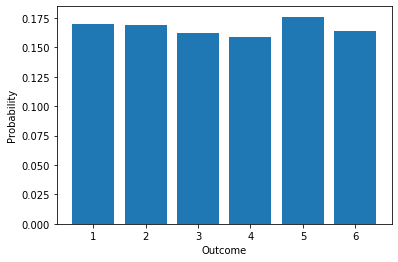

In [58]:
from empiricaldist import Pmf

pmf = Pmf.from_seq(sample)
pmf.bar()
plt.xlabel('Outcome')
plt.ylabel('Probability');

To simulate rolling two dice, I'll create an array with 1000 rows and 2 columns.

In [59]:
a = roll(size=(1000, 2))
a.shape

(1000, 2)

And then add up the columns.

In [7]:
sample2 = a.sum(axis=1)
sample2.shape

(1000,)

The result is a sample of 1000 sums of two dice.  Here's what that PMF looks like.

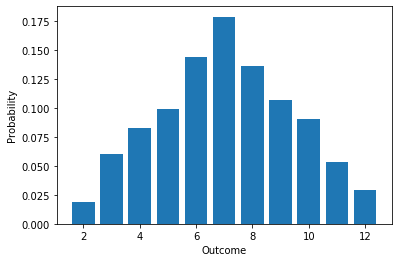

In [60]:
pmf2 = Pmf.from_seq(sample2)
pmf2.bar()
plt.xlabel('Outcome')
plt.ylabel('Probability');

And here's what it looks like with three dice.

In [61]:
a = roll(size=(1000, 3))
sample3 = a.sum(axis=1)

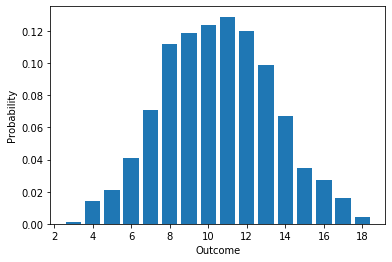

In [62]:
pmf3 = Pmf.from_seq(sample3)
pmf3.bar()
plt.xlabel('Outcome')
plt.ylabel('Probability');

With one die, the distribution is uniform.  With two dice, it's a triangle.  With three dice, it starts to have the shape of a bell curve.

Here are the three PMFs on the same axes, for comparison.

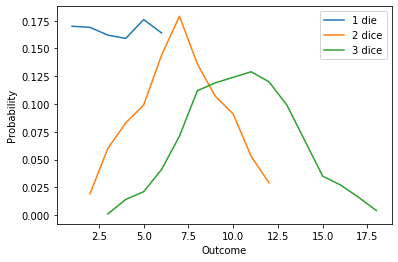

In [63]:
pmf.plot(label='1 die')
pmf2.plot(label='2 dice')
pmf3.plot(label='3 dice')
plt.xlabel('Outcome')
plt.ylabel('Probability')
plt.legend();

## Gamma distributions

In the previous section, we saw that the sum of values from a uniform distribution starts to look like a bell curve when we add up just a few values.

Now let's do the same thing with values from a gamma distribution.

NumPy provides a function to generate random values from a gamma distribution with a given mean.

In [64]:
mean = 2
gamma_sample = np.random.gamma(mean, size=1000)

Here's what the distribution looks like, this time using a CDF.

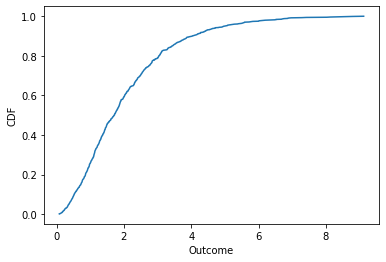

In [76]:
from empiricaldist import Cdf

cdf1 = Cdf.from_seq(gamma_sample)
cdf1.plot()

plt.xlabel('Outcome')
plt.ylabel('CDF');

It doesn't look like like a normal distribution.  To see the differences more clearly, we can plot the CDF of the data on top of a normal model with the same mean and standard deviation.

In [77]:
from scipy.stats import norm

def plot_normal_model(sample, **options):
    """Plot the CDF of a normal distribution with the
    same mean and std of the sample.
    
    sample: sequence of values
    options: passed to plt.plot
    """
    mean, std = np.mean(sample), np.std(sample)
    xs = np.linspace(np.min(sample), np.max(sample))
    ys = norm.cdf(xs, mean, std)
    plt.plot(xs, ys, alpha=0.4, **options)

Here's what that looks like for a gamma distribution with mean 2.

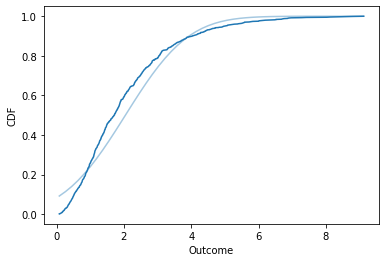

In [78]:
from empiricaldist import Cdf

plot_normal_model(gamma_sample, color='C0', label='Normal model')
cdf1.plot(label='Sample 1')

plt.xlabel('Outcome')
plt.ylabel('CDF');

There are clear differences between the data and the model.  Let's see how that looks when we start adding up values.

The following function computes the sum of gamma distributions with a given mean.

In [79]:
def sum_of_gammas(mean, num):
    """Sample the sum of gamma variates.
    
    mean: mean of the gamma distribution
    num: number of values to add up
    """
    a = np.random.gamma(mean, size=(1000, num))
    sample = a.sum(axis=1)
    return sample

Here's what the sum of two gamma variates looks like:

In [80]:
gamma_sample2 = sum_of_gammas(2, 2)
cdf2 = Cdf.from_seq(gamma_sample2)

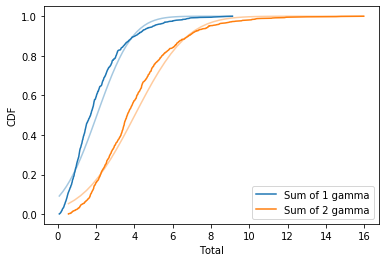

In [81]:
plot_normal_model(gamma_sample, color='C0')
cdf1.plot(label='Sum of 1 gamma')

plot_normal_model(gamma_sample2, color='C1')
cdf2.plot(label='Sum of 2 gamma')

plt.xlabel('Total')
plt.ylabel('CDF')
plt.legend();

The normal model is a better fit for the sum of two gamma variates, but there are still evident differences.  Let's see how big `num` has to be before it converges.

First I'll wrap the previous example in a function.

In [82]:
def plot_gammas(mean, nums):
    """Plot the sum of gamma variates and a normal model.
    
    mean: mean of the gamma distribution
    nums: sequence of sizes
    """
    for num in nums:
        sample = sum_of_gammas(mean, num)

        plot_normal_model(sample, color='gray')
        Cdf.from_seq(sample).plot(label=f'num = {num}')

    plt.xlabel('Total')
    plt.ylabel('CDF')
    plt.legend()

With `mean=2` it doesn't take long for the sum of gamma variates to approximate a normal distribution.

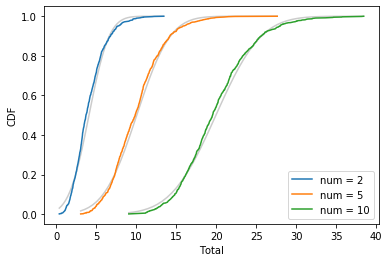

In [83]:
mean = 2
plot_gammas(mean, [2, 5, 10])

However, that doesn't mean that all gamma distribution behave the same way.  In general, the higher the variance, the longer it takes to converge.

With a gamma distribution, smaller means lead to higher variance.  With `mean=0.2`, the sum of 10 values is still not normal.

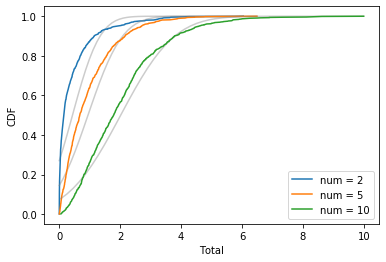

In [84]:
mean = 0.2
plot_gammas(mean, [2, 5, 10])

We have to crank `num` up to 100 before the convergence looks good.

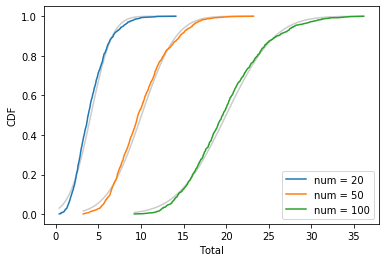

In [85]:
mean = 0.2
plot_gammas(mean, [20, 50, 100])

With `mean=0.02`, we have to add up 1000 values before the distribution looks normal.

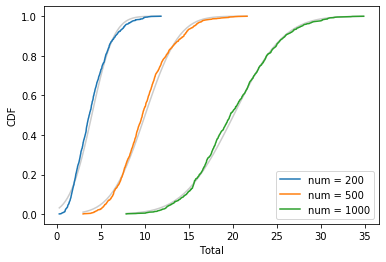

In [87]:
mean = 0.02
plot_gammas(mean, [200, 500, 1000])

## Pareto distributions

The gamma distributions in the previous section have higher variance that the uniform distribution we started with, so we have to add up more values to get the distribution of the sum to look normal.

The Pareto distribution is even more extreme.  Depending on the parameter, `alpha`, the variance can be large, very large, or infinite.

Here's a function that generates the sum of values from a Pareto distribution with a given parameter.

In [37]:
def sum_of_paretos(alpha, num):
    a = np.random.pareto(alpha, size=(1000, num))
    sample = a.sum(axis=1)
    return sample

And here's a function that plots the results.

In [88]:
def plot_paretos(mean, nums):
    for num in nums:
        sample = sum_of_paretos(mean, num)

        plot_normal_model(sample, color='gray')
        Cdf.from_seq(sample).plot(label=f'num = {num}')

    plt.xlabel('Total')
    plt.ylabel('CDF')
    plt.legend()

With `alpha=3` the Pareto distribution is relatively well-behaved, and the sum converges to a normal distribution with a moderate number of values.

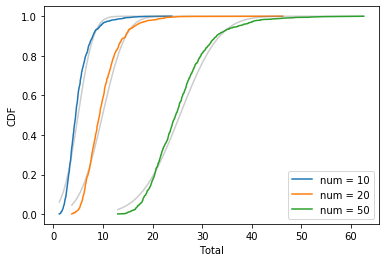

In [89]:
alpha = 3
plot_paretos(alpha, [10, 20, 50])

With `alpha=2`, we don't get very good convergence even with 1000 values.

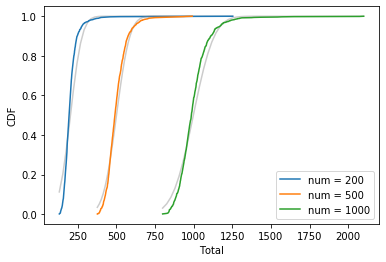

In [90]:
alpha = 2
plot_paretos(alpha, [200, 500, 1000])

With `alpha=1.5`, it's even worse.

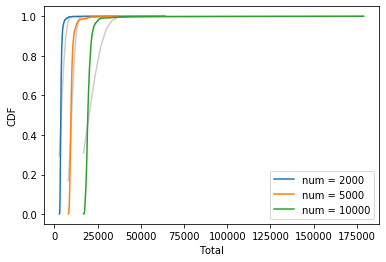

In [53]:
alpha = 1.5
plot_paretos(alpha, [2000, 5000, 10000])

And with `alpha=1`, it's beyond hopeless.

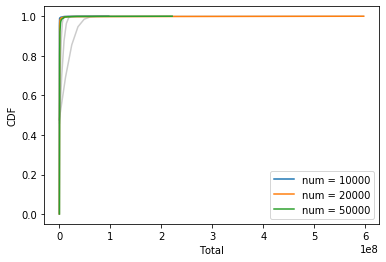

In [91]:
alpha = 1
plot_paretos(alpha, [10000, 20000, 50000])

In fact, when `alpha` is 2 or less, the variance of the Pareto distribution is infinite, and the central limit theorem does not apply.  The disrtribution of the sum never converges to a normal distribution.

However, there is no practical difference between a distribution like Pareto that never converges and other high-variance distributions that converge in theory, but only with an impractical number of values.

## Summary

The central limit theorem is an important result in mathematical statistics.  And it explains why so many distributions in the natural and engineered world are approximately normal.

But it doesn't always apply:

* In theory the central limit theorem doesn't apply when variance is infinite.

* In practice it might be irrelevant when variance is high.
